<a href="https://colab.research.google.com/github/lemarkick/textMining/blob/main/Sentiment_buying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.9 kB/s 
     |████████████████████████████████| 1.6 MB 23.1 MB/s 
     |████████████████████████████████| 5.8 MB 31.6 MB/s 
     |████████████████████████████████| 438 kB 66.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [1]:
import pandas as pd

filepath = "/content/drive/MyDrive/Colab Notebooks/TextMining/waimai_10k.csv"
pd_all = pd.read_csv(filepath)

print('評論數目（全部）：%d' % pd_all.shape[0])
print('評論數目（正面）：%d' % pd_all[pd_all.label==1].shape[0])
print('評論數目（負面）：%d' % pd_all[pd_all.label==0].shape[0])

評論數目（全部）：11987
評論數目（正面）：4000
評論數目（負面）：7987


In [2]:
import csv
import numpy as np
def read_files():
    path = filepath
    label = []
    all_texts = []
    all_label = []
    #取得review資料
    with open(path, newline='') as csvfile_train:
        reader = csv.DictReader(csvfile_train)
        content = [row['review'] for row in reader]
        all_texts+=content
    #取得label資料
    with open(path, newline='') as csvfile_label:
        reader = csv.DictReader(csvfile_label)
        tag = [row['label'] for row in reader]
        label+=tag
    #將label list的值轉為int格式
    all_label = list(map(int, label))
    return all_texts,all_label

In [3]:
train,label=read_files()
print(train[3999])
print(label[3999])
print(train[4000])
print(label[4000])

味道不錯,配送速度比預計快
1
菜品質量好，味道好，就是百度的問題，總是用運力原因來解釋，我也不懂這是什麼原因，晚了三個小時呵呵厲害吧！反正訂了就退不了，只能乾等……
0


In [4]:
train = train[:8000]
label = label[:8000]

In [5]:
import random
x_shuffle=train
y_shuffle=label
z_shuffle = list(zip(x_shuffle, y_shuffle))

random.shuffle(z_shuffle)

x_train, y_label = zip(*z_shuffle)

In [6]:
print(label[:10])
print(y_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
(0, 1, 1, 1, 1, 1, 1, 1, 0, 0)


In [7]:
from keras.utils import np_utils
y_label = np_utils.to_categorical(y_label, 2)

In [8]:
NUM_TRAIN = int(8000 * 0.8)
train, test = x_train[:NUM_TRAIN], x_train[NUM_TRAIN:]
labels_train, labels_test = y_label[:NUM_TRAIN], y_label[NUM_TRAIN:]

In [9]:
stopWords=[]
with open('/content/drive/MyDrive/Colab Notebooks/TextMining/stopWord.txt', 'r', encoding='utf8') as f:
    stopWords = f.read().split('\n') 
stopWords.append('\n')

In [10]:
import jieba
sentence=[]
sentence_test=[]

#透過jieba分詞工具，分別處理train和test資料
for content in train:
    _sentence=list(jieba.cut(content, cut_all=True))
    sentence.append(_sentence)
for content in test:
    _sentence=list(jieba.cut(content, cut_all=True))
    sentence_test.append(_sentence)

remainderWords2 = []
remainderWords_test = []

#將斷詞分別從train和test資料中移除
for content in sentence:
    remainderWords2.append(list(filter(lambda a: a not in stopWords, content)))
for content in sentence_test:
    remainderWords_test.append(list(filter(lambda a: a not in stopWords, content)))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.824 seconds.
Prefix dict has been built successfully.


In [11]:
print(train[:2])
print(remainderWords2[:2])

('時間超長，給的超少', '湯灑了些，量不錯不過灑了弄得袋子有些髒。雞蛋非常好吃！')
[['時', '間', '超', '長', '超', '少'], ['湯', '灑', '量', '錯', '灑', '弄', '袋子', '髒', '雞', '蛋', '非常', '好吃']]


In [12]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer(num_words=3000)
token.fit_on_texts(remainderWords2)

In [13]:
x_train_seq = token.texts_to_sequences(remainderWords2)
x_test_seq = token.texts_to_sequences(remainderWords_test)

In [14]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq, maxlen=50)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test_seq, maxlen=50)

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding

In [16]:
model = Sequential()

model.add(Embedding(output_dim=128, input_dim=3000, input_length=50))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=256, activation='relu' ))
model.add(Dropout(0.2))

model.add(Dense(units=2, activation='sigmoid' ))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           384000    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 256)               1638656   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,023,170
Trainable params: 2,023,170
Non-

In [17]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
              
train_history =model.fit(x_train, 
                         labels_train,
                         batch_size=100, 
                         epochs=10,
                         verbose=2,
                         validation_split=0.2)

Epoch 1/10
52/52 - 3s - loss: 0.5981 - accuracy: 0.6709 - val_loss: 0.4304 - val_accuracy: 0.8273 - 3s/epoch - 59ms/step
Epoch 2/10
52/52 - 2s - loss: 0.3427 - accuracy: 0.8561 - val_loss: 0.3427 - val_accuracy: 0.8492 - 2s/epoch - 38ms/step
Epoch 3/10
52/52 - 2s - loss: 0.2398 - accuracy: 0.9123 - val_loss: 0.3447 - val_accuracy: 0.8547 - 2s/epoch - 38ms/step
Epoch 4/10
52/52 - 2s - loss: 0.1688 - accuracy: 0.9432 - val_loss: 0.3921 - val_accuracy: 0.8414 - 2s/epoch - 38ms/step
Epoch 5/10
52/52 - 2s - loss: 0.1242 - accuracy: 0.9596 - val_loss: 0.4344 - val_accuracy: 0.8414 - 2s/epoch - 39ms/step
Epoch 6/10
52/52 - 2s - loss: 0.0930 - accuracy: 0.9689 - val_loss: 0.5054 - val_accuracy: 0.8391 - 2s/epoch - 38ms/step
Epoch 7/10
52/52 - 2s - loss: 0.0799 - accuracy: 0.9752 - val_loss: 0.5310 - val_accuracy: 0.8344 - 2s/epoch - 38ms/step
Epoch 8/10
52/52 - 3s - loss: 0.0638 - accuracy: 0.9805 - val_loss: 0.5574 - val_accuracy: 0.8180 - 3s/epoch - 49ms/step
Epoch 9/10
52/52 - 3s - loss: 0.

In [18]:
predict = np.argmax(model.predict(x_test), axis=-1)
[i for i,prob in enumerate(predict) if prob > 0.5]

def display_test_Sentiment(i):
    print(test[i])
    print('原始結果:',labels_test[i])
    print('預測結果:',predict[i])

In [19]:
display_test_Sentiment(1)


菜還真心不錯，米飯真心摳啊，老闆逃荒過啊
原始結果: [1. 0.]
預測結果: 1


In [20]:
scores = model.evaluate(x_test, labels_test, verbose=1)
scores[1]

50/50 [==============================] - 0s 6ms/step - loss: 0.6876 - accuracy: 0.8087


0.8087499737739563

In [21]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

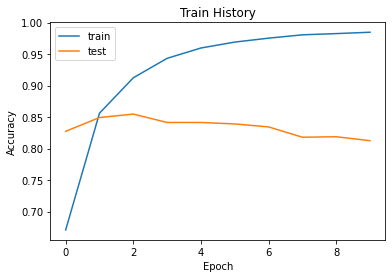

In [22]:
show_train_history('accuracy','val_accuracy')

In [23]:
from collections import Counter
segments=[]
segments_postive=[]
segments_negative=[]

#全部訓練資料分詞
for content in train:
    _sentence=list(jieba.cut(content, cut_all=True))
    segments+=_sentence

#去除訓練、正面與負面評論的停用詞
remainderWords = list(filter(lambda a: a not in stopWords, segments))

In [81]:
sorted(Counter(remainderWords).items(), key=lambda x:x[1], reverse=True)

[('送', 2364),
 (',', 1929),
 ('點', 1475),
 ('餐', 1340),
 ('沒', 1336),
 ('時', 1238),
 ('好吃', 1062),
 ('吃', 1048),
 ('錯', 1025),
 ('味道', 949),
 ('餅', 665),
 ('快', 646),
 ('飯', 579),
 ('太', 556),
 ('肉', 535),
 ('說', 534),
 ('速度', 494),
 ('菜', 426),
 ('裡', 408),
 ('非常', 403),
 ('送到', 395),
 ('訂', 392),
 ('差', 373),
 ('卷', 372),
 ('兩', 370),
 ('員', 370),
 ('話', 369),
 ('賣', 348),
 ('單', 348),
 ('很快', 343),
 ('電', 337),
 ('超', 336),
 ('難', 336),
 ('.', 329),
 ('慢', 328),
 ('會', 314),
 ('評', 312),
 ('涼', 311),
 ('服', 301),
 ('度', 300),
 ('態', 298),
 ('贊', 296),
 ('雞', 294),
 ('粥', 285),
 ('務', 282),
 ('間', 281),
 ('不好', 277),
 ('包', 273),
 ('外', 271),
 ('謝', 270),
 ('特', 265),
 ('什', 263),
 ('實', 254),
 ('量', 253),
 ('配送', 248),
 ('太慢', 246),
 ('裝', 243),
 ('少', 237),
 ('樣', 235),
 ('半', 222),
 ('百度', 219),
 ('小哥', 217),
 ('一次', 216),
 ('鐘', 214),
 ('感', 212),
 ('絲', 205),
 ('遞', 198),
 ('覺', 194),
 ('醬', 193),
 ('辛苦', 191),
 ('挺', 191),
 ('分', 187),
 ('～', 187),
 ('面', 180),
 ('次', 179),
 ('

In [74]:
model = Sequential()

model.add(Embedding(output_dim=128, input_dim=3000, input_length=50))
model.add(tf.keras.layers.LSTM(units=64, activation='sigmoid', recurrent_activation='hard_sigmoid'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=256, activation='relu' ))
model.add(Dropout(0.2))

model.add(Dense(units=2, activation='sigmoid' ))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 50, 128)           384000    
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 256)               16640     
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_35 (Dense)            (None, 2)               

In [75]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [76]:
train_history =model.fit(x_train, 
                         labels_train,
                         batch_size=100, 
                         epochs=10,
                         verbose=2,
                         validation_split=0.2)

Epoch 1/10
52/52 - 57s - loss: 0.6947 - accuracy: 0.5135 - val_loss: 0.6818 - val_accuracy: 0.4945 - 57s/epoch - 1s/step
Epoch 2/10
52/52 - 5s - loss: 0.5925 - accuracy: 0.7008 - val_loss: 0.4724 - val_accuracy: 0.7773 - 5s/epoch - 103ms/step
Epoch 3/10
52/52 - 6s - loss: 0.4049 - accuracy: 0.8219 - val_loss: 0.4234 - val_accuracy: 0.8062 - 6s/epoch - 118ms/step
Epoch 4/10
52/52 - 8s - loss: 0.3223 - accuracy: 0.8689 - val_loss: 0.3905 - val_accuracy: 0.8320 - 8s/epoch - 156ms/step
Epoch 5/10
52/52 - 5s - loss: 0.2627 - accuracy: 0.9004 - val_loss: 0.3868 - val_accuracy: 0.8430 - 5s/epoch - 106ms/step
Epoch 6/10
52/52 - 5s - loss: 0.2432 - accuracy: 0.9049 - val_loss: 0.3984 - val_accuracy: 0.8406 - 5s/epoch - 104ms/step
Epoch 7/10
52/52 - 6s - loss: 0.2169 - accuracy: 0.9203 - val_loss: 0.4292 - val_accuracy: 0.8289 - 6s/epoch - 106ms/step
Epoch 8/10
52/52 - 7s - loss: 0.2011 - accuracy: 0.9279 - val_loss: 0.4458 - val_accuracy: 0.8383 - 7s/epoch - 127ms/step
Epoch 9/10
52/52 - 5s - l

In [79]:
scores = model.evaluate(x_test, labels_test, verbose=1)
scores[1]

50/50 [==============================] - 1s 12ms/step - loss: 0.4943 - accuracy: 0.8288


0.8287500143051147

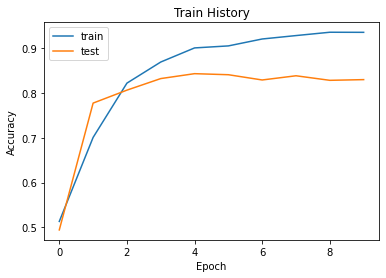

In [80]:
show_train_history('accuracy','val_accuracy')